In [519]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, MultiHeadAttention, LayerNormalization, Dropout
import yfinance as yf
import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler

end_date = datetime.datetime.now() 
start_date = end_date - datetime.timedelta(days = 365 * 5) # we are using 5 years of historical data
data = yf.download('TSLA', start=start_date.date(), end=end_date.date())

# Fetch historical data for TSLA
# data = yf.download('TSLA', start='2020-01-01', end='2023-01-01')

# Use High, Low, Open, Close features
features = data[['High', 'Low', 'Open', 'Close']].values

SEQLEN = 100

[*********************100%%**********************]  1 of 1 completed


In [520]:
# Function to create dataset for multi-feature input
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length) ])
        y.append(data[i + sequence_length, 3]) # Target is the Close price
    return np.array(X), np.array(y)

X, y = create_dataset(features, SEQLEN)

# Split dataset into training and testing
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Initialize the StandardScaler
# scaler = StandardScaler()
scaler=MinMaxScaler()
# Fit on training data only
# Since X_train is 3D (samples, SEQLEN, features) and StandardScaler works on 2D,
# you need to reshape X_train to 2D, scale it, then reshape it back to 3D.
num_instances, num_steps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, num_features)  # Reshape to 2D

scaler.fit(X_train_reshaped)  # Fit scaler to training data

X_train_scaled = scaler.transform(X_train_reshaped).reshape(num_instances, num_steps, num_features)

num_instances_test, _, _ = X_test.shape
X_test_scaled = scaler.transform(X_test.reshape(-1, num_features)).reshape(num_instances_test, num_steps, num_features)

scaler_target = StandardScaler()

y_train_reshaped = y_train.reshape(-1, 1)

# Fit the scaler on the training target data
scaler_target.fit(y_train_reshaped)

# Transform the training target data
y_train_scaled = scaler_target.transform(y_train_reshaped)

# Transform the testing target data (ensure to reshape y_test if it's 1D)
y_test_scaled = scaler_target.transform(y_test.reshape(-1, 1))



In [521]:
class SinusoidalPositionalEncoding(tf.keras.layers.Layer): 
    def __init__(self, sequence_size, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.pos_encoding = self.positional_encoding(sequence_size, embedding_dim)
    
    def get_angles(self, position, i, embedding_dim):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(embedding_dim, tf.float32))
        return position * angles
    
    def positional_encoding(self, sequence_size, embedding_dim):
        angle_rads = self.get_angles(position=tf.range(sequence_size, dtype=tf.float32)[:, tf.newaxis],
                                     i=tf.range(embedding_dim, dtype=tf.float32)[tf.newaxis, :],
                                     embedding_dim=embedding_dim)
        # Apply sin to even indices in the array; 2i
        sines = tf.math.sin(angle_rads[:, 0::2])
        # Apply cos to odd indices in the array; 2i+1
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[: , :tf.shape(inputs)[1], :]


In [522]:
# Time2Vec 
# for a single feature f
# t2v_f(t)[i] = { 
#    i = 0: ω_i t + φ_i 
#    1<=i<=k: sin(ω_i t + φ_i)
# }
class Time2Vec(tf.keras.layers.Layer):
    def __init__(self, kernel_size=10, **kwargs):
        super(Time2Vec, self).__init__(**kwargs)
        self.k = kernel_size

    def build(self, input_shape):
        feature_size = input_shape[-1]  # Last dimension is feature_size
        
        # Initialize weights without batch_size dimension
        self.wl = self.add_weight(name='wl', shape=(1, feature_size), initializer='uniform', trainable=True)
        self.bl = self.add_weight(name='bl', shape=(1, feature_size), initializer='uniform', trainable=True)
        
        # Initialize weights for the periodic components
        self.wp = self.add_weight(name='wp', shape=(self.k, feature_size), initializer='uniform', trainable=True)
        self.bp = self.add_weight(name='bp', shape=(self.k, feature_size), initializer='uniform', trainable=True)
        
    def call(self, inputs):
        feature_size = tf.shape(inputs)[2]  # Last dimension is feature_size
        seq_length = tf.shape(inputs)[1]
        batch_size = tf.shape(inputs)[0]
        
        # Generate a time index tensor [0, 1, ..., seq_length-1] normalized
        time_indices = tf.range(start=0, limit=seq_length, dtype=tf.float32) / tf.cast(seq_length-1, tf.float32)
        
        time_indices = tf.expand_dims(time_indices, axis=0)
        time_indices = tf.tile(time_indices, multiples=[batch_size, 1])

        time_indices = tf.expand_dims(time_indices, axis=-1)
        time_indices = tf.tile(time_indices, multiples=[1, 1, feature_size])


      
        linear_out = self.wl * time_indices + self.bl
        linear_out = tf.expand_dims(linear_out, axis=2)

        # print("Linear time indices:", time_indices.shape)


        time_indices = tf.expand_dims(time_indices, axis=2)
        time_indices = tf.tile(time_indices, multiples=[1, 1, self.k, 1])

        # print("Inputs shape", inputs.shape)
        # print("Linear shape", linear_out.shape)
        # print("Periodic time indices:", time_indices.shape)
        # print("wp:", self.wp.shape)


        periodic_out = tf.sin(time_indices * self.wp + self.bp)

        # print("Periodic out shape", periodic_out.shape)

        
        time2vec = tf.concat([linear_out, periodic_out], 2)
        # print("time2vec concat", time2vec.shape)
        time2vec = tf.reshape(time2vec, [batch_size, seq_length, (self.k+1)*feature_size])
        # print("time2vec reshape", time2vec.shape)

        # time2vec = tf.expand_dims(time2vec, axis=0)

        print("time2vec", time2vec.shape)


        output = tf.concat([inputs, time2vec], axis=-1)
        
        return output




In [523]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, feature_size, num_heads=2, head_size=128, ff_dim=None, dropout=0.1, t2vk = 0, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.feature_size = feature_size + feature_size * (t2vk+1)
        if t2vk == 0:
            self.feature_size = feature_size

        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout = dropout

        # For a single head
        # K_t = W^K x_t
        # Q_t = W^Q x_t
        # V_t = W^V x_t
        # Attention(i,j) = softmax((K_i^T Q_j) / sqrt(dimK))
        # O_t = sum_j(Attention(t,j) v_j)

        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)
        self.attention_dropout = layers.Dropout(dropout)
        self.attention_norm = layers.LayerNormalization(epsilon=1e-6)

        self.dense = layers.Dense(ff_dim, activation="relu")
        self.dense_dropout = layers.Dropout(dropout)
        self.dense_project = layers.Dense(self.feature_size)
        self.dense_norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=False):
        print(inputs.shape)
        attn = self.attention(inputs, inputs)
        attn = self.attention_dropout(attn, training=training)
        attn = self.attention_norm(inputs + attn)

        ffn = self.dense(attn)
        ffn = self.dense_dropout(ffn, training=training)
        ffn = self.dense_project(ffn)
        # assert ffn.shape[-1] == attn.shape[-1], "FFN output dimension must match attention output."

        output = self.dense_norm(attn + ffn)
        return output



In [524]:
# Define the transformer model
def Transformer(sequence_size, feature_size=4, num_heads=2, head_size = 128, ff_dim=64, dropout=0.1, num_transformer_blocks=2):
    inputs = layers.Input(shape=(sequence_size, feature_size))
    x = SinusoidalPositionalEncoding(sequence_size, feature_size)(inputs)
    # kernel_size = 10
    # x = Time2Vec(kernel_size=kernel_size)(inputs)
    
    # x = layers.Conv1D(filters=64, kernel_size=3, padding='same')(x)


    for _ in range(num_transformer_blocks):
        # x = TransformerBlock(feature_size=feature_size, num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout, t2vk=kernel_size)(x)
        x = TransformerBlock(feature_size=feature_size, num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout)(x)

    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1)(x)
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

model = Transformer(SEQLEN, feature_size=4, num_heads=2, head_size = 256, ff_dim=64, num_transformer_blocks=3)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=100, verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(X_train_scaled, y_train_scaled, batch_size=32, epochs=400, callbacks=[early_stopping], validation_split=0.2, verbose=1)

# Evaluate the model on the test set
test_metrics = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Test Metrics (Loss, MSE, MAE, MAPE): {test_metrics}')

# Predict and inverse-transform the normalization for the Close price
predictions = model.predict(X_test_scaled)
predictions = scaler_target.inverse_transform(predictions)

(None, 100, 4)
(None, 100, 4)
(None, 100, 4)


Epoch 1/400
(None, 100, 4)
(None, 100, 4)
(None, 100, 4)
(None, 100, 4)
(None, 100, 4)
(None, 100, 4)
23/24 [===========================>..] - ETA: 0s - loss: 0.6697 - mean_squared_error: 0.6697 - mean_absolute_error: 0.6688 - mean_absolute_percentage_error: 90.4124(None, 100, 4)
(None, 100, 4)
(None, 100, 4)
24/24 [==============================] - 7s 201ms/step - loss: 0.6698 - mean_squared_error: 0.6698 - mean_absolute_error: 0.6692 - mean_absolute_percentage_error: 90.4528 - val_loss: 0.6711 - val_mean_squared_error: 0.6711 - val_mean_absolute_error: 0.6878 - val_mean_absolute_percentage_error: 1258.4236
Epoch 2/400
24/24 [==============================] - 3s 115ms/step - loss: 0.2214 - mean_squared_error: 0.2214 - mean_absolute_error: 0.3946 - mean_absolute_percentage_error: 92.5667 - val_loss: 0.6288 - val_mean_squared_error: 0.6288 - val_mean_absolute_error: 0.6721 - val_mean_absolute_percentage_error: 1281.9347
Epoch 3/400
24/24 [==============================] - 3s 114ms/step 

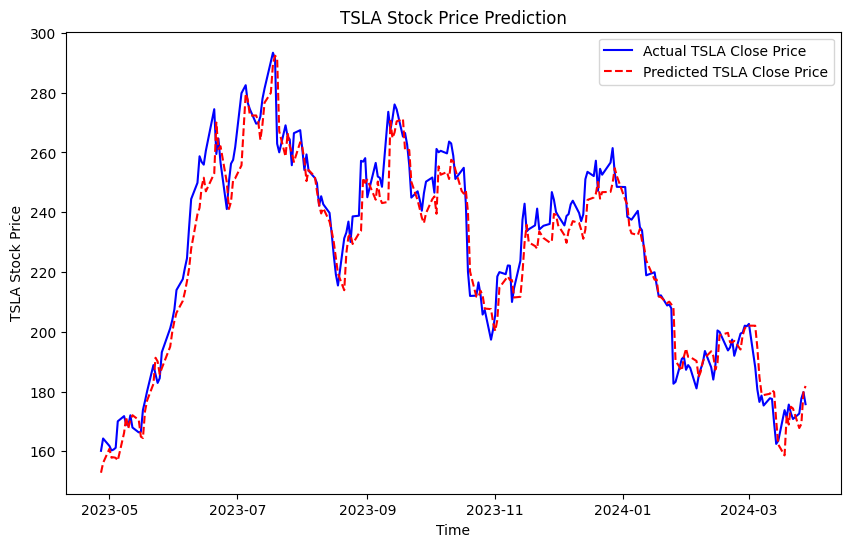

In [525]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# plt.plot(y_test, label='Actual TSLA Close Price', color='blue')
# plt.plot(predictions, label='Predicted TSLA Close Price', color='red', linestyle='--')
plt.plot(data.index[-len(y_test):], data['Close'].tail(len(y_test)), label='Actual TSLA Close Price', color='blue')
plt.plot(data.index[-len(y_test):], predictions, label='Predicted TSLA Close Price', color='red', linestyle='--')
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TSLA Stock Price')
plt.legend()
plt.show()